## Pumpkin Pricing

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pumpkins = pd.read_csv('../data/US-pumpkins.csv')

pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [3]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


C:\Users\Kazan\AppData\Local\Temp\ipykernel_19660\2637987050.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)


,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

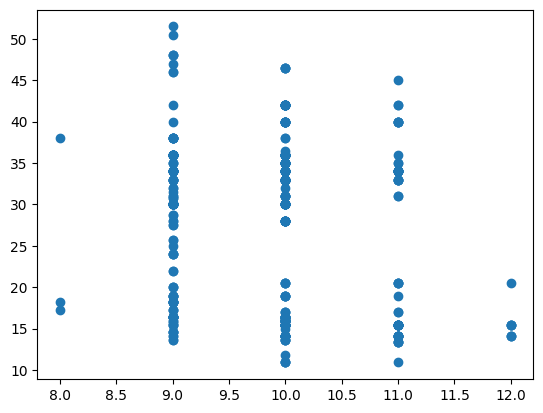

In [4]:
import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins, )

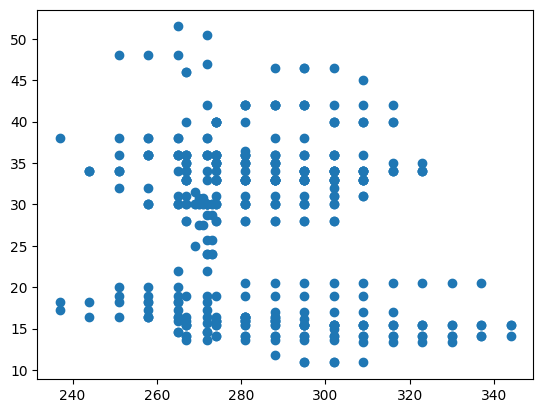

In [5]:

plt.scatter('DayOfYear','Price',data=new_pumpkins)

In [6]:
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))

-0.16673322492745407
-0.14878293554077535


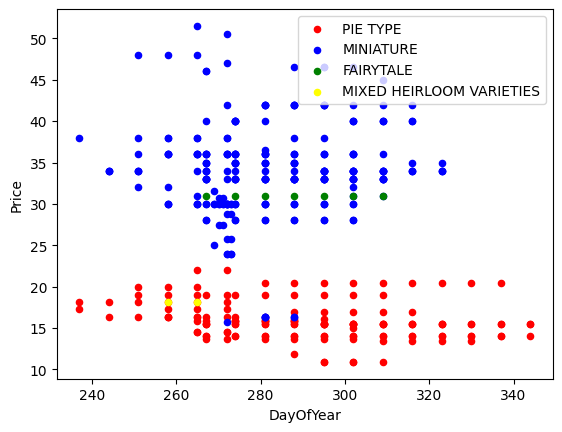

In [7]:
colors = ['red','blue','green','yellow']

ax=None
for i, var in enumerate(new_pumpkins['Variety'].unique()):
    df = new_pumpkins[new_pumpkins['Variety']==var]
    ax = df.plot.scatter( 'DayOfYear' , 'Price' ,ax=ax, c=colors[i],label=var)

<Axes: xlabel='Variety'>

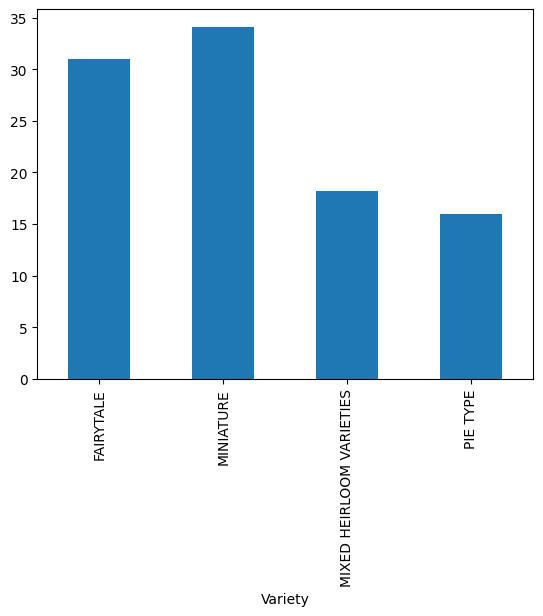

In [8]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

<Axes: xlabel='DayOfYear', ylabel='Price'>

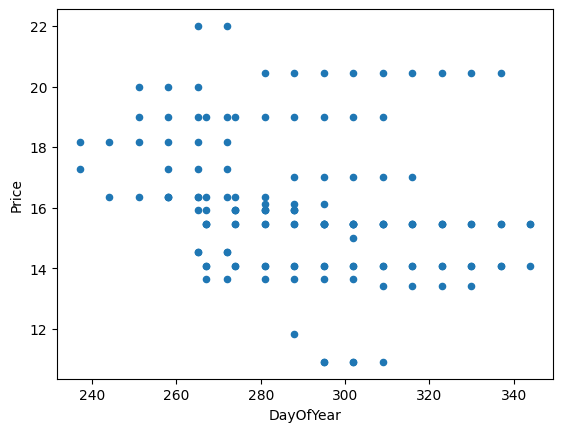

In [9]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety'] == 'PIE TYPE']
pie_pumpkins.plot.scatter('DayOfYear','Price')

In [10]:
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
print(pie_pumpkins['Month'].corr(pie_pumpkins['Price']))

-0.2669192282197318
-0.23841413206125714


In [11]:

X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [13]:
pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.77 (17.2%)
Model determination:  0.04460606335028361


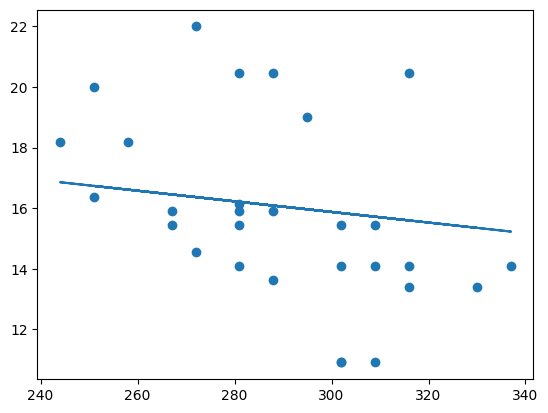

In [14]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [16]:
pred = pipeline.predict(sorted(X_test))

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.87 (17.9%)
Model determination:  0.07639977655280128


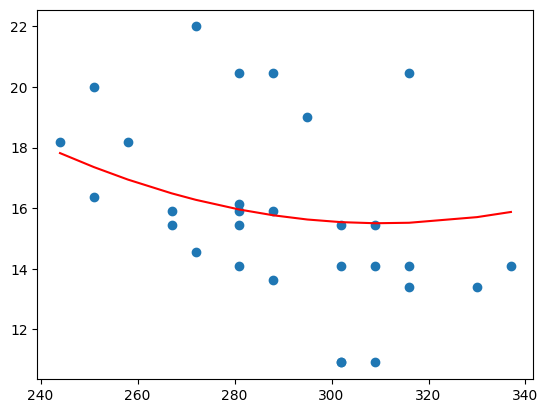

In [17]:
plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pred, c = 'red')

In [18]:
X = pd.get_dummies(new_pumpkins['Variety'],dtype=int)\
                  .join(new_pumpkins['Month'])\
                  .join(pd.get_dummies(new_pumpkins['City'],dtype=int))\
                  .join(pd.get_dummies(new_pumpkins['Package'],dtype=int))
X

,FAIRYTALE,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE,Month,ATLANTA,BALTIMORE,BOSTON,CHICAGO,COLUMBIA,DETROIT,NEW YORK,PHILADELPHIA,SAN FRANCISCO,ST. LOUIS,1 1/9 bushel cartons,1 1/9 bushel crates,1/2 bushel cartons,bushel baskets,bushel cartons
70,0,0,0,1,9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
71,0,0,0,1,9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
72,0,0,0,1,10,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
73,0,0,0,1,10,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
74,0,0,0,1,10,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,0,1,0,0,9,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1739,0,1,0,0,9,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1740,0,1,0,0,9,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1741,0,1,0,0,9,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [19]:
y = new_pumpkins['Price']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)


Mean error: 2.84 (10.6%)
Model determination:  0.9401337786025454


In [23]:
# Polynomial regression
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.46 (9.04%)
Model determination:  0.9574946889701916


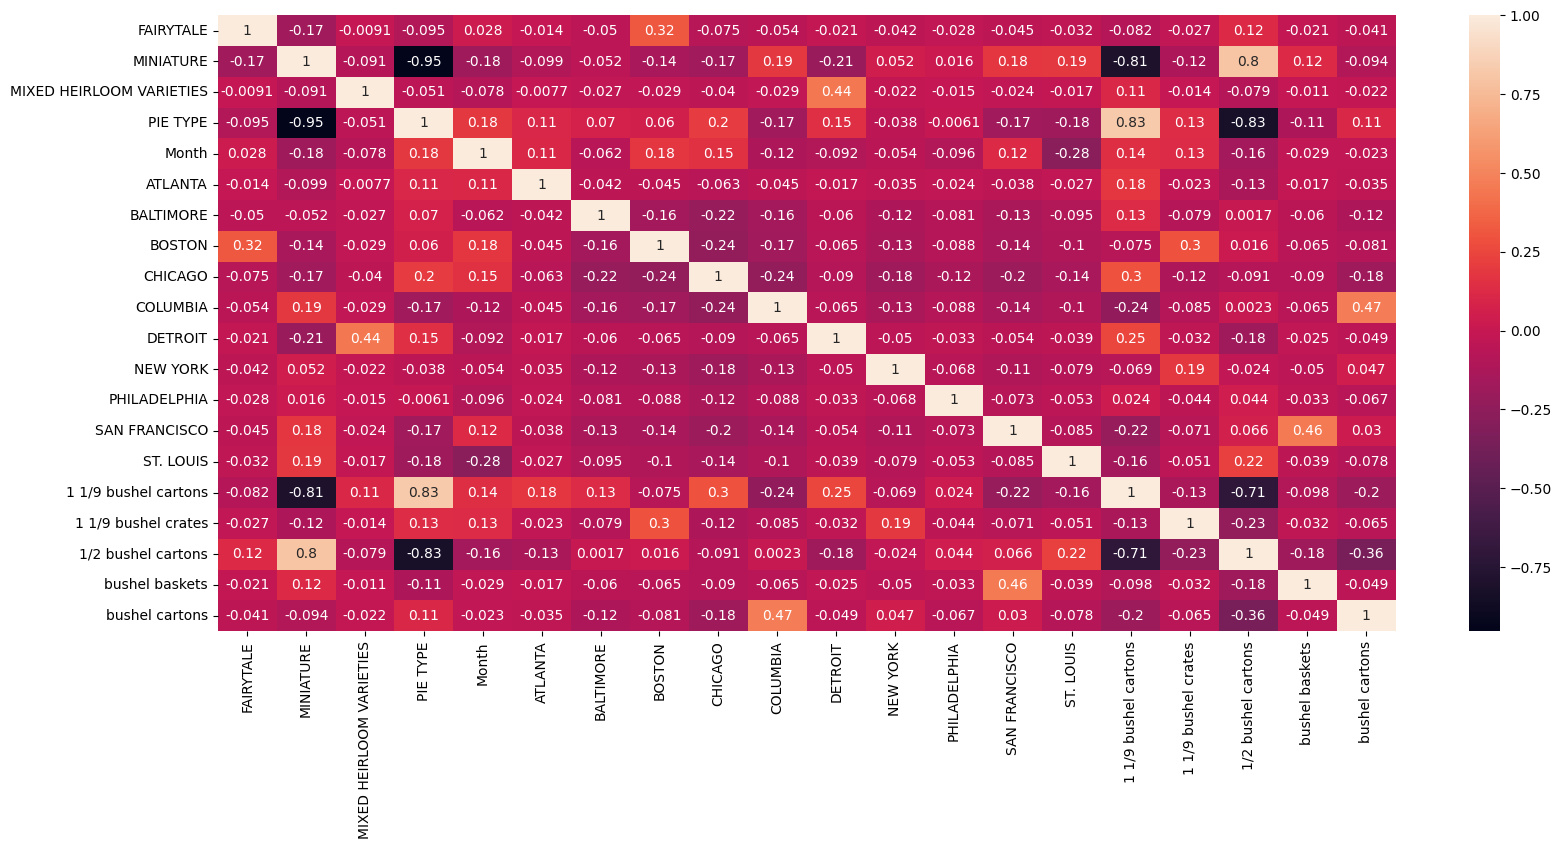

In [26]:
import seaborn as sn
plt.subplots(figsize=(19,8))
sn.heatmap(X.corr(), annot=True)
plt.show()